# Title

This is a test

In [7]:
1 + 1

2

Notice how the code chunk below does not show by default, but its output does!

In [8]:
# code-fold: true
for i in range(10):
    print(i)

0
1
2
3
4
5
6
7
8
9


## Imports

In [9]:
import skimage.io as skio
import skimage.util as sku
import skimage.color as skol
from skimage import filters, feature, transform
import skimage.morphology as skimor
import skimage.draw as draw
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np
import cv2
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from scipy.ndimage import gaussian_filter, gaussian_laplace
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import datasets
import tensorflow.keras.backend as K



import skimage.morphology as skm
from skimage.color import rgb2gray
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.random import sample_without_replacement
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_laplace
from scipy.ndimage import maximum_filter
from scipy.ndimage import minimum_filter
from scipy.ndimage import median_filter

## Functions

In [10]:
# Function to compute DICE
smooth=1
def dice_coef(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)
        
# Function to print several accuracy metrics
def accuracy_metrics(y_true, y_pred):
    # Create confusion matrix
    C = confusion_matrix(y_true, y_pred, labels=(True, False))

    # Overall accuracy rate
    acc = (C[0,0] + C[1,1])/C.sum()

    # Recall
    recall = (C[0,0])/(C[0,0] + C[1,0])
    
    # Precision
    prec = (C[0,0])/(C[0,0] + C[0,1])

    # DICE
    dice = dice_coef(y_true, y_pred)


    # Print results
    print("Confusion matrix:\n", C)
    print("Overall accuracy:", np.round(acc, 3), "\nPrecision:", np.round(recall, 3),
            "\nRecall", np.round(prec, 3), "\nDICE:", np.round(dice, 3))

# Function to create input layer
def classify_gray(image):

    # Compute the standard deviation of the r, g, and b channels
    std_dev = np.std(image, axis = 2)

    # Define a threshold for classifying gray pixels
    diff_threshold = 6 # Adjust as needed

    # Classify pixels as gray or not gray based on the standard deviation
    gray_mask = std_dev < diff_threshold
        
    return gray_mask
    
# Function to compute layers for additional model features
def compute_features(img, include_categorical = True):    
    # Range of values (gray pixels will have low range)
    r = img.max(axis = 2) - img.min(axis = 2)

    if include_categorical:
        
        # Canny edge detection
        canny_edges_r = feature.canny(img[:,:,0], sigma=4)
        canny_edges_g = feature.canny(img[:,:,1], sigma=4)
        canny_edges_b = feature.canny(img[:,:,2], sigma=4)

         # Calculation Canny gradient
        image_gray = rgb2gray(img)
        canny_edges = feature.canny(image_gray, sigma=3)
    
        # Create disk
        disk = skm.disk(1)
    
        # Area closing for hough lines
        closed_edges = skm.dilation(canny_edges, footprint = disk)
        closed_edges = closed_edges * 255
    
        lines = transform.probabilistic_hough_line(closed_edges, threshold=5, line_length=25, line_gap=3)
        hough_lines = np.zeros(image_gray.shape, dtype=np.uint8)
    
        # Draw the detected lines on the canvas
        for line in lines:
            p0, p1 = line
            # Draw line segment
            rr, cc = draw.line(p0[1], p0[0], p1[1], p1[0])
            hough_lines[rr, cc] = 255  # Set the pixel values to white (255) along the line
    
        #create gray mask
        gray_mask = classify_gray(img)
        gray_mask = gray_mask.reshape((img.shape[0], img.shape[1]))
    

        img = np.dstack([img, canny_edges_r, canny_edges_g, canny_edges_b, gray_mask, hough_lines])
        
    
    # Gaussian blur sigma = 1
    gaus_r_1 = gaussian_filter(img[:,:,0], sigma = 1)
    gaus_g_1 = gaussian_filter(img[:,:,1], sigma = 1)
    gaus_b_1 = gaussian_filter(img[:,:,2], sigma = 1)
    
    # Gaussian blur sigma = 3
    gaus_r_3 = gaussian_filter(img[:,:,0], sigma = 3)
    gaus_g_3 = gaussian_filter(img[:,:,1], sigma = 3)
    gaus_b_3 = gaussian_filter(img[:,:,2], sigma = 3)

    # Gaussian blur sigma = 5
    gaus_r_5 = gaussian_filter(img[:,:,0], sigma = 5)
    gaus_g_5 = gaussian_filter(img[:,:,1], sigma = 5)
    gaus_b_5 = gaussian_filter(img[:,:,2], sigma = 5)
    
    # LoG blur sigma = .5
    log_r_5 = gaussian_laplace(img[:,:,0], sigma = .5)
    log_g_5 = gaussian_laplace(img[:,:,1], sigma = .5)
    log_b_5 = gaussian_laplace(img[:,:,2], sigma = .5)
    
    # LoG blur sigma = .6
    log_r_6 = gaussian_laplace(img[:,:,0], sigma = .6)
    log_g_6 = gaussian_laplace(img[:,:,1], sigma = .6)
    log_b_6 = gaussian_laplace(img[:,:,2], sigma = .6)
    
    # LoG blur sigma = .8
    log_r_8 = gaussian_laplace(img[:,:,0], sigma = .8)
    log_g_8 = gaussian_laplace(img[:,:,1], sigma = .8)
    log_b_8 = gaussian_laplace(img[:,:,2], sigma = .8)
    
    # Add layers to model
    return np.dstack([img, r,
                     gaus_r_1, gaus_g_1, gaus_b_1, gaus_r_3, gaus_g_3, gaus_b_3,
                     gaus_r_5, gaus_g_5, gaus_b_5, log_r_5, log_g_5, log_b_5,
                     log_r_6, log_g_6, log_b_6, log_r_8, log_g_8, log_b_8])

def identify_road_cluster(clustered_image, image_label):

    cluster_labels = np.unique(clustered_image)

    best_recall = 0
    best_cluster = -1

    for i in cluster_labels:
        cluster = (clustered_image==i)
        C = confusion_matrix(image_label.ravel(), cluster.ravel(), labels=(True, False))

        # # Overall accuracy rate
        # acc = (C[0,0] + C[1,1])/C.sum()
        # # Recall
        recall = (C[0,0])/(C[0,0] + C[1,0])
        # Precision
        # prec = (C[0,0])/(C[0,0] + C[0,1])

        if recall > best_recall:
            best_recall = recall
            best_cluster = i

    return best_cluster

## Introduction

## Methods

### Creating Image Filters

### Principle Components Analysis

Principal Component Analysis (PCA) was utilized to assess the possibility of cutting down on the number of features input into the various models. Currently there are about [NUMBER OF FEATURES] filtered and calculated features extracted from each 1500x1500 RGB image. With scaling this process, cutting down of this preprocessing step and the size of the image into the models could provide large increases in speed and storage needed to run this process. PCA is a commonly used tool for dimensionality reduction across data science. PCA is especially helpful when a dataset has multiple potentially correlated and redundant features and it is unclear which features are most important. In this situation, many of the features generated from our satellite images may provide very similar information or are highly correlated. PCA 

### K-Means Clustering

K-Means Clustering is a basic unsupervised machine learning algorithm that groups data points into k clusters, the value of k can be chosen by the user. The centroids of each cluster are initialized randomly as three data points and all points are assigned to the cluster nearest to them. Then the mean coordinates of all the points in each cluster is calculated and this value is now the new centroid for that cluster. Then the process is repeated until a maximum number of interactions is reached or the centroids spot changing significantly between each interaction. Although there were only two categories in this study; road and background, k was chosen to be three. This is because it was found by (Maurya, et al) to keep the clusters containing the roads from including other non-road features. 

K-Means clustering was run on features extracted from the full 1500x1500 images, two sets of features were used. First was all features discussed in the previous section and the second was the top 5 principle components accessed by PCA. 


### Random Forest

### U-Net

## Results

### Creating Image Filters

### PCA

Read in our image and label and crop them

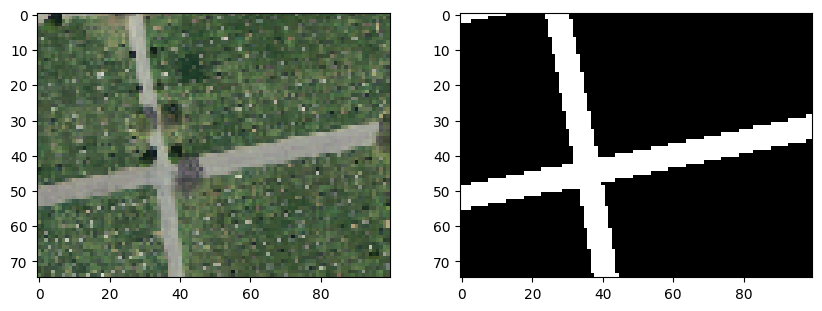

In [11]:
pca_img = skio.imread("../data/massRoads/tiff/train/10528735_15.tiff")
pca_img_label = skio.imread("../data/massRoads/tiff/train_labels/10528735_15.tif")

x1, x2 = 1200, 1300
y1, y2 = 300, 375
pca_img_cropped = pca_img[y1:y2, x1:x2, :]
pca_img_label_cropped = pca_img_label[y1:y2, x1:x2]

fig, axes = plt.subplots(1,2, figsize = (10,15))

axes[0].imshow(pca_img_cropped)
axes[1].imshow(pca_img_label_cropped, cmap='gray')

plt.show()

Get all filters of the image

In [12]:
pca_filters = compute_features(pca_img_cropped)

Show top 10 components

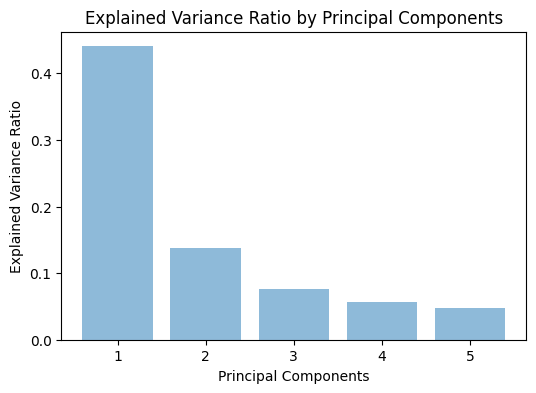

In [13]:
pca_layers = pca_filters.reshape(pca_filters.shape[0] * pca_filters.shape[1], pca_filters.shape[2])
# Standardize the features
scaler = StandardScaler()
pca_layers_scaled = scaler.fit_transform(pca_layers)

# Initialize PCA and fit the scaled data
pca_5 = PCA(n_components=5)
# layers_pca = pca_10.fit_transform(pca_layers_scaled)
pca_5_comps = pca_5.fit_transform(pca_layers_scaled)

# Explained variance ratio
explained_variance_ratio_5 = pca_5.explained_variance_ratio_

# Plotting the explained variance ratio
plt.figure(figsize=(6, 4))
plt.bar(range(1, len(explained_variance_ratio_5) + 1), explained_variance_ratio_5, alpha=0.5, align='center')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.title('Explained Variance Ratio by Principal Components')
plt.show()

In [14]:
# Initialize PCA and fit the scaled data
pca_3 = PCA(n_components=3)
# layers_pca = pca_10.fit_transform(pca_layers_scaled)
pca_3_comps = pca_3.fit_transform(pca_layers_scaled)

Display labelled data points in 3D

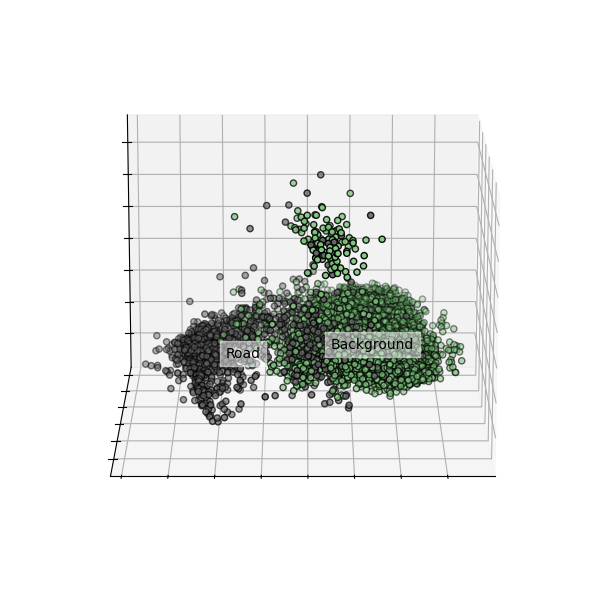

In [15]:
fig = plt.figure(1, figsize=(6, 6))
plt.clf()

ax = fig.add_subplot(111, projection="3d", elev=15, azim=90)
ax.set_position([0, 0, 0.95, 1])

X = pca_3_comps
y = pca_img_label_cropped.ravel()

for name, label in [("Background", 0), ("Road", 255)]:
    ax.text3D(
        X[y == label, 0].mean(),
        X[y == label, 1].mean() + 1.5,
        X[y == label, 2].mean(),
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.5, edgecolor="w", facecolor="w"),
    )
# Reorder the labels to have colors matching the cluster results
# y = np.choose(y, [0, 255]).astype(float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='Accent', edgecolor="k")

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

plt.show()

### K-Means Clustering

Load in test image, this image will be used to test all methods

In [16]:
test_image = skio.imread("../data/massRoads/tiff/train/21929005_15.tiff")
test_image_label = skio.imread("../data/massRoads/tiff/train_labels/21929005_15.tif")
test_image_label_bool = (test_image_label==255)

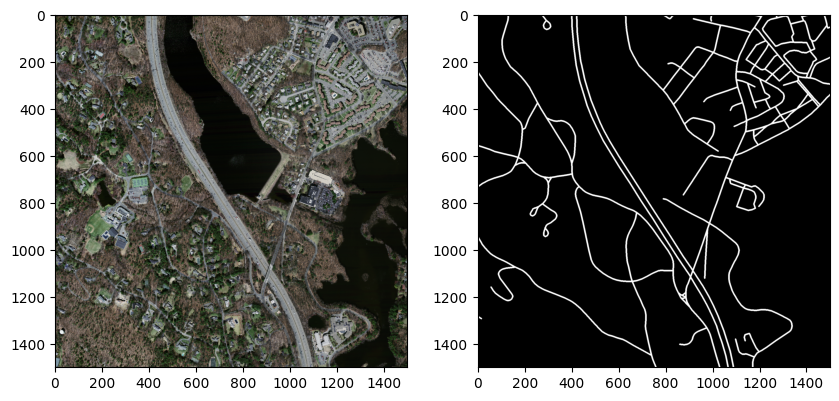

In [17]:
fig, axes = plt.subplots(1,2, figsize = (10,15))

axes[0].imshow(test_image)
axes[1].imshow(test_image_label, cmap='gray')

plt.show()

Get all feature layers and pca top 5 layers for input into K-Means

In [18]:
test_filters = compute_features(test_image)
test_layers = test_filters.reshape(test_filters.shape[0] * test_filters.shape[1], test_filters.shape[2])

# Standardize the features
test_layers_scaled = scaler.fit_transform(test_layers)

# Initialize PCA and fit the scaled data
test_pca_5 = PCA(n_components=5)
# layers_pca = pca_10.fit_transform(pca_layers_scaled)
test_pca_5_layers = test_pca_5.fit_transform(test_layers_scaled)

Run K-Means on all features

In [19]:
kmeans_all_layers = KMeans(n_clusters=3, verbose=1).fit(test_layers)

Initialization complete
Iteration 0, inertia 187644101367.0.
Iteration 1, inertia 125545139434.50027.
Iteration 2, inertia 120875049331.41293.
Iteration 3, inertia 115766259010.02931.
Iteration 4, inertia 113324901734.78314.
Iteration 5, inertia 112428103872.62338.
Iteration 6, inertia 112164657630.1813.
Iteration 7, inertia 112104061919.19244.
Iteration 8, inertia 112082698894.38023.
Iteration 9, inertia 112072800837.27078.
Iteration 10, inertia 112067755202.40671.
Iteration 11, inertia 112065208673.3103.
Iteration 12, inertia 112063913785.92903.
Iteration 13, inertia 112063238341.41156.
Converged at iteration 13: center shift 0.2790394877320488 within tolerance 0.29131851506544154.


Reshape our segmented image, identify which layer is the layer with the roads, and print metrics

In [20]:
segmented_image_all_layers = kmeans_all_layers.labels_.reshape((test_image.shape[0], test_image.shape[1]))
road_cluster_num = identify_road_cluster(segmented_image_all_layers, test_image_label_bool)
road_cluster = (segmented_image_all_layers==road_cluster_num)
accuracy_metrics(test_image_label_bool.ravel(), road_cluster.ravel())

Confusion matrix:
 [[  96284   43981]
 [ 885867 1223868]]
Overall accuracy: 0.587 
Precision: 0.098 
Recall 0.686 
DICE: 0.172


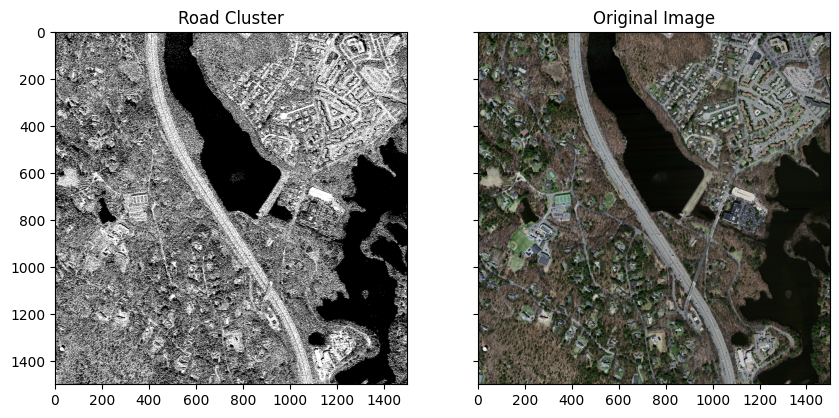

In [21]:
# Show cluster and original image
fig, axes = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True)

axes[0].imshow(road_cluster, cmap='gray')
axes[0].set_title('Road Cluster')

axes[1].imshow(test_image)
axes[1].set_title('Original Image')

plt.show()

Run K-Means on the PCA filters

In [22]:
kmeans_pca = KMeans(n_clusters=3, verbose=1).fit(test_pca_5_layers)

Initialization complete
Iteration 0, inertia 36333281.10500867.
Iteration 1, inertia 25604187.080977257.
Iteration 2, inertia 24435423.46986088.
Iteration 3, inertia 23727263.916382674.
Iteration 4, inertia 23028106.578016374.
Iteration 5, inertia 22608733.064606465.
Iteration 6, inertia 22443533.744842347.
Iteration 7, inertia 22368552.58206838.
Iteration 8, inertia 22325026.835472915.
Iteration 9, inertia 22297504.072010823.
Iteration 10, inertia 22279900.67080389.
Iteration 11, inertia 22268790.686190054.
Iteration 12, inertia 22261907.03081488.
Iteration 13, inertia 22257506.707177993.
Iteration 14, inertia 22254732.041071482.
Iteration 15, inertia 22253034.780233197.
Iteration 16, inertia 22251971.842813272.
Iteration 17, inertia 22251324.165352784.
Converged at iteration 17: center shift 0.00031803460788747205 within tolerance 0.00041369156176637354.


In [23]:
segmented_image_pca = kmeans_pca.labels_.reshape((test_image.shape[0], test_image.shape[1]))
pca_road_cluster_num = identify_road_cluster(segmented_image_pca, test_image_label_bool)
pca_road_cluster = (segmented_image_pca==pca_road_cluster_num)
accuracy_metrics(test_image_label_bool.ravel(), pca_road_cluster.ravel())

Confusion matrix:
 [[  93487   46778]
 [ 414177 1695558]]
Overall accuracy: 0.795 
Precision: 0.184 
Recall 0.667 
DICE: 0.289


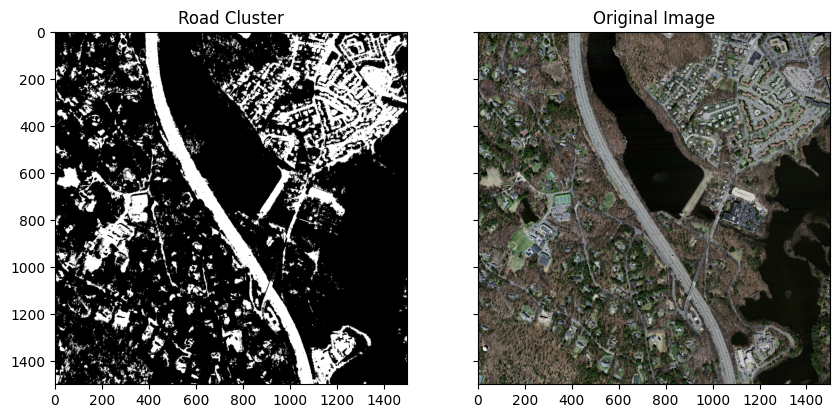

In [24]:
# Show cluster and original image
fig, axes = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True)

axes[0].imshow(pca_road_cluster, cmap='gray')
axes[0].set_title('Road Cluster')

axes[1].imshow(test_image)
axes[1].set_title('Original Image')

plt.show()